# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [40]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import display
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [7]:
pasta_input = Path(r"C:\Users\Priscila\Desktop\EBAC - DATA SCIENCE\Desenvolvimento Modelos com Pandas e Python\Regressão Logística I\Pratique II\input")
arquivo = pasta_input / "processed.cleveland.data"

colunas = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','num']

# leitura robusta (encoding simples)
df = pd.read_csv(arquivo, header=None, names=colunas, sep=",", na_values="?", encoding="latin-1")

# garantir numéricos
for c in colunas:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# alvo binário
df["flag_doente"] = (df["num"] != 0).astype("int64")

display(df.head())
print(df.shape)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


(303, 15)


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           299 non-null    float64
 12  thal         301 non-null    float64
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 35.6 KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [9]:
def bivariada_qualitativa(df: pd.DataFrame, resposta: str, explicativa: str) -> pd.DataFrame:
    """
    Eu monto uma bivariada para uma variável qualitativa.
    A resposta precisa ser binária (0/1).
    """
    tab = (
        df[[resposta, explicativa]]
        .dropna()
        .groupby(explicativa)[resposta]
        .agg(doentes='sum', total='count')
        .reset_index()
    )
    tab['saudaveis'] = tab['total'] - tab['doentes']
    tab['media_doentes'] = tab['doentes'] / tab['total']

    # Odds (com correção leve pra evitar divisão por zero)
    tab['odds'] = (tab['doentes'] + 0.5) / (tab['saudaveis'] + 0.5)

    # Referência = total
    doentes_total = tab['doentes'].sum()
    total_total = tab['total'].sum()
    saudaveis_total = total_total - doentes_total
    odds_total = (doentes_total + 0.5) / (saudaveis_total + 0.5)

    tab['odds_ratio_ref_total'] = tab['odds'] / odds_total
    tab['logito'] = np.log(tab['odds'])
    tab['woe'] = np.log(tab['odds_ratio_ref_total'])

    # Linha Total (referência)
    linha_total = pd.DataFrame([{
        explicativa: 'Total',
        'saudaveis': saudaveis_total,
        'doentes': doentes_total,
        'total': total_total,
        'media_doentes': doentes_total / total_total,
        'odds': odds_total,
        'odds_ratio_ref_total': 1.0,
        'logito': np.log(odds_total),
        'woe': 0.0
    }])

    tab = pd.concat([tab, linha_total], ignore_index=True)

    # Reordena colunas
    tab = tab[[explicativa, 'saudaveis', 'doentes', 'total', 'media_doentes', 'odds',
               'odds_ratio_ref_total', 'logito', 'woe']]
    return tab


In [10]:
biv_sex = bivariada_qualitativa(df, 'flag_doente', 'sex')
biv_cp = bivariada_qualitativa(df, 'flag_doente', 'cp')
biv_exang = bivariada_qualitativa(df, 'flag_doente', 'exang')

display(biv_sex.head())
print(f"shape biv_sex: {biv_sex.shape}")

display(biv_cp.head())
print(f"shape biv_cp: {biv_cp.shape}")

display(biv_exang.head())
print(f"shape biv_exang: {biv_exang.shape}")


,sex,saudaveis,doentes,total,media_doentes,odds,odds_ratio_ref_total,logito,woe
0,0.0,72,25,97,0.257732,0.351724,0.414757,-1.044908,-0.880062
1,1.0,92,114,206,0.553398,1.237838,1.459673,0.213366,0.378212
2,Total,164,139,303,0.458746,0.848024,1.000000,-0.164846,0.000000


shape biv_sex: (3, 9)


,cp,saudaveis,doentes,total,media_doentes,odds,odds_ratio_ref_total,logito,woe
0,1.0,16,7,23,0.304348,0.454545,0.536005,-0.788457,-0.623611
1,2.0,41,9,50,0.180000,0.228916,0.269940,-1.474402,-1.309556
2,3.0,68,18,86,0.209302,0.270073,0.318473,-1.309063,-1.144217
3,4.0,39,105,144,0.729167,2.670886,3.149539,0.982410,1.147256
4,Total,164,139,303,0.458746,0.848024,1.000000,-0.164846,0.000000


shape biv_cp: (5, 9)


,exang,saudaveis,doentes,total,media_doentes,odds,odds_ratio_ref_total,logito,woe
0,0.0,141,63,204,0.308824,0.448763,0.529187,-0.801260,-0.636414
1,1.0,23,76,99,0.767677,3.255319,3.838710,1.180290,1.345136
2,Total,164,139,303,0.458746,0.848024,1.000000,-0.164846,0.000000


shape biv_exang: (3, 9)


In [11]:
def amplitude_woe(biv: pd.DataFrame, nome_var: str) -> float:
    biv2 = biv[biv[nome_var] != 'Total'].copy()
    return float(biv2['woe'].max() - biv2['woe'].min())

amp = pd.DataFrame({
    'variavel': ['sex', 'cp', 'exang'],
    'amplitude_woe': [
        amplitude_woe(biv_sex, 'sex'),
        amplitude_woe(biv_cp, 'cp'),
        amplitude_woe(biv_exang, 'exang')
    ]
}).sort_values('amplitude_woe', ascending=False)

display(amp.head())
print(f"Maior amplitude_woe: {amp.iloc[0]['variavel']} = {amp.iloc[0]['amplitude_woe']:.4f}")


,variavel,amplitude_woe
1,cp,2.456812
2,exang,1.981550
0,sex,1.258274


Maior amplitude_woe: cp = 2.4568


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [28]:
def bivariada_continua(base: pd.DataFrame, resposta: str, var: str, n_grupos: int = 5) -> pd.DataFrame:
    """
    Categorização de variável contínua em n_grupos e bivariada.
    Retorna: faixa, media_var, saudaveis, doentes, total, media_doentes, odds,
    odds_ratio_ref_total, logito, woe + linha Total.
    """
    df2 = base[[resposta, var]].copy()
    df2 = df2.dropna(subset=[resposta, var])

    # Cria faixas (categorias)
    df2['faixa'] = pd.cut(df2[var], bins=n_grupos)

    # Média da variável dentro de cada faixa
    medias_var = df2.groupby('faixa', observed=True)[var].mean().reset_index()
    medias_var = medias_var.rename(columns={var: f'media_{var}'})

    # Contagens por faixa
    tab = df2.groupby('faixa', observed=True)[resposta].agg(['count', 'sum']).reset_index()
    tab = tab.rename(columns={'count': 'total', 'sum': 'doentes'})
    tab['saudaveis'] = tab['total'] - tab['doentes']
    tab['media_doentes'] = tab['doentes'] / tab['total']

    # Odds por faixa
    tab['odds'] = tab['media_doentes'] / (1 - tab['media_doentes'])

    # Odds total (referência)
    doentes_total = tab['doentes'].sum()
    total_total = tab['total'].sum()
    media_total = doentes_total / total_total
    odds_total = media_total / (1 - media_total)

    tab['odds_ratio_ref_total'] = tab['odds'] / odds_total
    tab['logito'] = np.log(tab['odds'])
    tab['woe'] = np.log(tab['odds_ratio_ref_total'])

    # Junta a média do "var" por faixa
    tab = tab.merge(medias_var, on='faixa', how='left')

    # Linha Total
    linha_total = pd.DataFrame([{
        'faixa': 'Total',
        f'media_{var}': base[var].mean(),
        'saudaveis': tab['saudaveis'].sum(),
        'doentes': tab['doentes'].sum(),
        'total': tab['total'].sum(),
        'media_doentes': media_total,
        'odds': odds_total,
        'odds_ratio_ref_total': 1.0,
        'logito': np.log(odds_total),
        'woe': 0.0
    }])

    tab = pd.concat([tab, linha_total], ignore_index=True)

    # Organiza colunas no padrão pedido
    tab = tab[['faixa', f'media_{var}', 'saudaveis', 'doentes', 'total', 'media_doentes',
               'odds', 'odds_ratio_ref_total', 'logito', 'woe']]

    return tab

In [29]:
biv_age = bivariada_continua(df, 'flag_doente', 'age', n_grupos=5)

display(biv_age.head())
print(f"Média geral de age: {df['age'].mean():.2f}")


,faixa,media_age,saudaveis,doentes,total,media_doentes,odds,odds_ratio_ref_total,logito,woe
0,"(28.952, 38.6]",35.181818,8,3,11,0.272727,0.375000,0.442446,-0.980829,-0.815437
1,"(38.6, 48.2]",43.704225,50,21,71,0.295775,0.420000,0.495540,-0.867501,-0.702108
2,"(48.2, 57.8]",53.567010,56,41,97,0.422680,0.732143,0.863823,-0.311780,-0.146387
3,"(57.8, 67.4]",61.775701,40,67,107,0.626168,1.675000,1.976259,0.515813,0.681206
4,"(67.4, 77.0]",70.529412,10,7,17,0.411765,0.700000,0.825899,-0.356675,-0.191282


Média geral de age: 54.44


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [39]:
df_model = df[['flag_doente', 'sex', 'cp', 'trestbps', 'age']].dropna().copy()

df_model['trestbps_fx'] = pd.qcut(df_model['trestbps'], q=5, duplicates='drop')

display(df_model[['flag_doente', 'sex', 'cp', 'trestbps', 'trestbps_fx', 'age']].head())
print(f"N (linhas usadas no modelo): {df_model.shape[0]}")

# 3) Modelo logístico: sex, cp e trestbps (em faixas) como qualitativas; age como quantitativa
modelo = smf.logit(
    'flag_doente ~ C(sex) + C(cp) + C(trestbps_fx) + age',
    data=df_model
).fit(disp=False)

# 4) Tabela de parâmetros com coeficientes, OR, p-valor e IC 95% do OR
params = modelo.params
conf = modelo.conf_int()
conf.columns = ['IC_2.5%', 'IC_97.5%']

tab_coef = pd.DataFrame({
    'coef': params,
    'OR': np.exp(params),
    'pvalor': modelo.pvalues,
    'OR_IC_2.5%': np.exp(conf['IC_2.5%']),
    'OR_IC_97.5%': np.exp(conf['IC_97.5%'])
}).sort_values('pvalor')

display(tab_coef)
print(f"Log-likelihood: {modelo.llf:.3f}")

,flag_doente,sex,cp,trestbps,trestbps_fx,age
0,0,1.0,1.0,145.0,"(144.6, 200.0]",63.0
1,1,1.0,4.0,160.0,"(144.6, 200.0]",67.0
2,1,1.0,4.0,120.0,"(93.999, 120.0]",67.0
3,0,1.0,3.0,130.0,"(126.0, 134.0]",37.0
4,0,0.0,2.0,130.0,"(126.0, 134.0]",41.0


N (linhas usadas no modelo): 303


,coef,OR,pvalor,OR_IC_2.5%,OR_IC_97.5%
C(sex)[T.1.0],1.765612,5.845150,6.681374e-07,2.913584,11.726377
Intercept,-6.110201,0.002220,1.399151e-06,0.000186,0.026563
C(cp)[T.4.0],2.458237,11.684192,9.056503e-06,3.946132,34.595994
age,0.057291,1.058963,2.026984e-03,1.021128,1.098201
"C(trestbps_fx)[T.Interval(144.6, 200.0, closed='right')]",0.858000,2.358438,4.966940e-02,1.001241,5.555339
"C(trestbps_fx)[T.Interval(120.0, 126.0, closed='right')]",0.702371,2.018533,2.238679e-01,0.650878,6.259974
"C(trestbps_fx)[T.Interval(126.0, 134.0, closed='right')]",0.472187,1.603497,2.642305e-01,0.699945,3.673438
C(cp)[T.2.0],-0.112956,0.893190,8.601312e-01,0.254266,3.137612
"C(trestbps_fx)[T.Interval(134.0, 144.6, closed='right')]",0.026551,1.026907,9.517341e-01,0.434659,2.426130
C(cp)[T.3.0],0.031891,1.032405,9.556597e-01,0.335444,3.177465


Log-likelihood: -144.155


4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

In [41]:
df_cal = df_model.copy()
df_cal["prob"] = modelo.predict(df_cal)

# G=5 grupos por quantil
df_cal["grupo_prob"] = pd.qcut(df_cal["prob"], q=5, duplicates="drop")

# >>> AQUI é onde estava o warning no seu print: agora vai com observed=True <<<
cal = (
    df_cal.groupby("grupo_prob", observed=True)
    .agg(
        prob_media=("prob", "mean"),
        taxa_observada=("flag_doente", "mean"),
        n=("flag_doente", "count")
    )
    .reset_index()
)

display(cal)
print(f"Qtd de grupos gerados: {cal.shape[0]}")


,grupo_prob,prob_media,taxa_observada,n
0,"(0.0127, 0.126]",0.067197,0.065574,61
1,"(0.126, 0.308]",0.210336,0.183333,60
2,"(0.308, 0.6]",0.437707,0.491803,61
3,"(0.6, 0.819]",0.701049,0.683333,60
4,"(0.819, 0.962]",0.877340,0.868852,61


Qtd de grupos gerados: 5


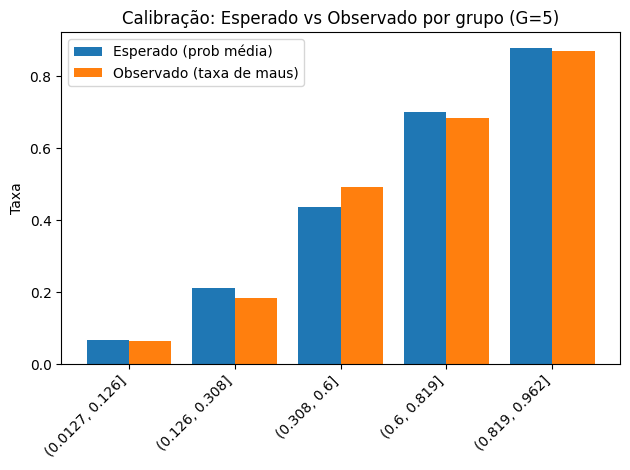

Esperado médio geral: 0.4587 | Observado geral: 0.4587


In [42]:
x = np.arange(len(cal))
plt.figure()
plt.bar(x - 0.2, cal["prob_media"], width=0.4, label="Esperado (prob média)")
plt.bar(x + 0.2, cal["taxa_observada"], width=0.4, label="Observado (taxa de maus)")
plt.xticks(x, cal["grupo_prob"].astype(str), rotation=45, ha="right")
plt.ylabel("Taxa")
plt.title("Calibração: Esperado vs Observado por grupo (G=5)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Esperado médio geral: {df_cal['prob'].mean():.4f} | Observado geral: {df_cal['flag_doente'].mean():.4f}")


5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [43]:
y_true = df_cal["flag_doente"].values
y_prob = df_cal["prob"].values
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)
gini = 2 * auc - 1

fpr, tpr, thr = roc_curve(y_true, y_prob)
ks = np.max(tpr - fpr)

print(f"Acurácia (threshold=0.5): {acc:.4f}")
print(f"AUC: {auc:.4f}")
print(f"GINI: {gini:.4f}")
print(f"KS: {ks:.4f}")

Acurácia (threshold=0.5): 0.7723
AUC: 0.8524
GINI: 0.7048
KS: 0.5739


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

,modelo,status,n,acc,auc,gini,ks
5,modelo_maior,ok,297,0.855219,0.931980,0.863960,0.754015
4,base+thalach+oldpeak+exang,ok,303,0.834983,0.895157,0.790314,0.670512
3,base+exang+oldpeak,ok,303,0.818482,0.888401,0.776803,0.642832
2,base+oldpeak,ok,303,0.815182,0.884278,0.768556,0.651606
1,base+exang,ok,303,0.788779,0.865349,0.730698,0.590279


Total de modelos testados: 6
Melhor modelo (por AUC): modelo_maior


,grupo_prob,prob_media,taxa_observada,n
0,"(0.0032199999999999998, 0.0608]",0.028382,0.050000,60
1,"(0.0608, 0.221]",0.126354,0.067797,59
2,"(0.221, 0.551]",0.362092,0.355932,59
3,"(0.551, 0.95]",0.805014,0.881356,59
4,"(0.95, 1.0]",0.983049,0.950000,60


Qtd de grupos gerados (calibração): 5


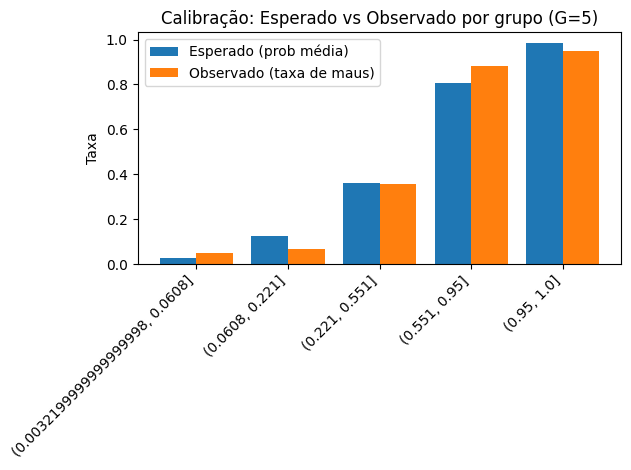

Acurácia do melhor modelo (threshold=0.5): 0.8552
AUC do melhor modelo: 0.9320 | GINI: 0.8640 | KS: 0.7540


In [44]:
# -----------------------------
# Função para avaliar um modelo
# -----------------------------
def avaliar_modelo(nome_modelo: str, formula: str, cols: list, base_df: pd.DataFrame, g_calib: int = 5):
    # pega só as colunas necessárias e remove NA
    df_tmp = base_df[cols].dropna().copy()

    # ajusta o modelo
    try:
        m = smf.logit(formula=formula, data=df_tmp).fit(disp=False)
    except Exception as e:
        return {
            "modelo": nome_modelo,
            "status": f"falhou: {type(e).__name__}",
            "n": df_tmp.shape[0],
            "acc": np.nan,
            "auc": np.nan,
            "gini": np.nan,
            "ks": np.nan,
            "obj": None,
            "df": None
        }

    # prevê prob
    df_tmp["prob"] = m.predict(df_tmp)

    # métricas de discriminação
    y_true = df_tmp["flag_doente"].values
    y_prob = df_tmp["prob"].values
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    gini = 2 * auc - 1

    fpr, tpr, thr = roc_curve(y_true, y_prob)
    ks = float(np.max(tpr - fpr))

    return {
        "modelo": nome_modelo,
        "status": "ok",
        "n": df_tmp.shape[0],
        "acc": float(acc),
        "auc": float(auc),
        "gini": float(gini),
        "ks": float(ks),
        "obj": m,
        "df": df_tmp
    }


# ---------------------------------------------------------
# Garantia: se trestbps_fx não existir, cria com 5 faixas
# ---------------------------------------------------------
if "trestbps_fx" not in df.columns:
    df["trestbps_fx"] = pd.cut(df["trestbps"], bins=5)


# ---------------------------------------------------------
# Modelos candidatos (base + melhorias)
# ---------------------------------------------------------
candidatos = [
    (
        "base_Q3",
        "flag_doente ~ C(sex) + C(cp) + C(trestbps_fx) + age",
        ["flag_doente", "sex", "cp", "trestbps_fx", "age"]
    ),
    (
        "base+exang",
        "flag_doente ~ C(sex) + C(cp) + C(trestbps_fx) + age + C(exang)",
        ["flag_doente", "sex", "cp", "trestbps_fx", "age", "exang"]
    ),
    (
        "base+oldpeak",
        "flag_doente ~ C(sex) + C(cp) + C(trestbps_fx) + age + oldpeak",
        ["flag_doente", "sex", "cp", "trestbps_fx", "age", "oldpeak"]
    ),
    (
        "base+exang+oldpeak",
        "flag_doente ~ C(sex) + C(cp) + C(trestbps_fx) + age + C(exang) + oldpeak",
        ["flag_doente", "sex", "cp", "trestbps_fx", "age", "exang", "oldpeak"]
    ),
    (
        "base+thalach+oldpeak+exang",
        "flag_doente ~ C(sex) + C(cp) + C(trestbps_fx) + age + thalach + oldpeak + C(exang)",
        ["flag_doente", "sex", "cp", "trestbps_fx", "age", "thalach", "oldpeak", "exang"]
    ),
    (
        "modelo_maior",
        "flag_doente ~ C(sex) + C(cp) + C(trestbps_fx) + age + thalach + oldpeak + C(exang) + C(slope) + ca + C(thal)",
        ["flag_doente", "sex", "cp", "trestbps_fx", "age", "thalach", "oldpeak", "exang", "slope", "ca", "thal"]
    ),
]

resultados = []
objetos = {}

for nome, formula, cols in candidatos:
    r = avaliar_modelo(nome, formula, cols, df)
    resultados.append({k: r[k] for k in ["modelo", "status", "n", "acc", "auc", "gini", "ks"]})
    objetos[nome] = r

res = pd.DataFrame(resultados).sort_values(["status", "auc", "ks"], ascending=[True, False, False])

display(res.head())
print(f"Total de modelos testados: {res.shape[0]}")

# escolhe o melhor (primeiro 'ok' com maior AUC)
res_ok = res[res["status"] == "ok"].copy()
melhor_nome = res_ok.iloc[0]["modelo"]
print(f"Melhor modelo (por AUC): {melhor_nome}")

# --------------------------------------------
# Reavalia CALIBRAÇÃO do melhor modelo (G=5)
# --------------------------------------------
melhor = objetos[melhor_nome]
df_cal = melhor["df"].copy()

df_cal["grupo_prob"] = pd.qcut(df_cal["prob"], q=5, duplicates="drop")

cal = (
    df_cal.groupby("grupo_prob", observed=True)
    .agg(
        prob_media=("prob", "mean"),
        taxa_observada=("flag_doente", "mean"),
        n=("flag_doente", "count")
    )
    .reset_index()
)

display(cal.head())
print(f"Qtd de grupos gerados (calibração): {cal.shape[0]}")

# gráfico: esperado vs observado por grupo
x = np.arange(len(cal))
plt.figure()
plt.bar(x - 0.2, cal["prob_media"], width=0.4, label="Esperado (prob média)")
plt.bar(x + 0.2, cal["taxa_observada"], width=0.4, label="Observado (taxa de maus)")
plt.xticks(x, cal["grupo_prob"].astype(str), rotation=45, ha="right")
plt.ylabel("Taxa")
plt.title("Calibração: Esperado vs Observado por grupo (G=5)")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Acurácia do melhor modelo (threshold=0.5): {res_ok.iloc[0]['acc']:.4f}")
print(f"AUC do melhor modelo: {res_ok.iloc[0]['auc']:.4f} | GINI: {res_ok.iloc[0]['gini']:.4f} | KS: {res_ok.iloc[0]['ks']:.4f}")
